In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import numpy as np

#### Process:
- Visualize the Time Series Data
- Make the time series data stationary
- Plot the correlation and autocorrelation Charts
- ARIMA or SARIMA modeling
- Predictions and Evaluations

In [2]:
df = pd.read_csv("full_store_trans.csv",index_col="date")
df.head()

,store_nbr,store_promo,sto_type,cluster,holi_type,locale,year,month,day,dcoilwtico_interpolated,store_trans_filled,weekday,weekend
date,,,,,,,,,,,,,
2013-01-02,1,0,D,13,NaN,NaN,2013,1,2,93.14,2111.0,3,0
2013-01-02,10,0,C,15,NaN,NaN,2013,1,2,93.14,1293.0,3,0
2013-01-02,17,0,C,12,NaN,NaN,2013,1,2,93.14,1580.0,3,0
2013-01-02,2,0,D,13,NaN,NaN,2013,1,2,93.14,2358.0,3,0
2013-01-02,20,0,B,6,NaN,NaN,2013,1,2,93.14,NaN,3,0


In [ ]:
df.loc[(df.index>='2015-02-13')&(df.store_nbr==20),'store_trans_filled	w

In [3]:
df = df.drop(columns=['sto_type','cluster','holi_type','locale'])

#### Train validation test split

In [4]:
df.index = pd.to_datetime(df.index)

#### 17 stores to predict, we will predict store 1 for now.

In [5]:
df1 = df[df["store_nbr"] == 1]
df1 = df1.drop(columns="store_nbr")

In [6]:
df1 

,store_promo,year,month,day,dcoilwtico_interpolated,store_trans_filled,weekday,weekend
date,,,,,,,,
2013-01-02,0,2013,1,2,93.140000,2111.0,3,0
2013-01-03,0,2013,1,3,92.970000,1833.0,4,0
2013-01-04,0,2013,1,4,93.120000,1863.0,5,0
2013-01-05,0,2013,1,5,93.146667,1509.0,0,1
2013-01-06,0,2013,1,6,93.173333,520.0,0,1
...,...,...,...,...,...,...,...,...
2017-08-11,216,2017,8,11,48.810000,570.0,5,0
2017-08-12,103,2017,8,12,48.403333,1004.0,0,1
2017-08-13,73,2017,8,13,47.996667,416.0,0,1


##### Check for null and fill null.

In [7]:
# remove duplicates
df1 = df1[~df1.index.duplicated(keep='first')]

In [8]:
df1

,store_promo,year,month,day,dcoilwtico_interpolated,store_trans_filled,weekday,weekend
date,,,,,,,,
2013-01-02,0,2013,1,2,93.140000,2111.0,3,0
2013-01-03,0,2013,1,3,92.970000,1833.0,4,0
2013-01-04,0,2013,1,4,93.120000,1863.0,5,0
2013-01-05,0,2013,1,5,93.146667,1509.0,0,1
2013-01-06,0,2013,1,6,93.173333,520.0,0,1
...,...,...,...,...,...,...,...,...
2017-08-11,216,2017,8,11,48.810000,570.0,5,0
2017-08-12,103,2017,8,12,48.403333,1004.0,0,1
2017-08-13,73,2017,8,13,47.996667,416.0,0,1


In [9]:
# Create a complete date range from the start to the end of your index
full_range = pd.date_range(start=df1.index.min(), end=df1.index.max(), freq='D')

# Identify any missing dates
missing_dates = full_range.difference(df1.index)

print("Missing dates:", missing_dates)

Missing dates: DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)


In [10]:
df1=df1.reindex(full_range)

In [11]:
# Use different methods to fill nulls for different columns
df1['dcoilwtico_interpolated'] = df1['dcoilwtico_interpolated'].ffill()
df1.loc[:, ['store_promo', 'store_trans_filled']] = df1.loc[:, ['store_promo', 'store_trans_filled']].fillna(0)
df1['year'] = df1['year'].fillna(pd.Series(df1.index.year, index=df1.index))
df1['month'] = df1['month'].fillna(pd.Series(df1.index.month, index=df1.index))
df1['day'] = df1['day'].fillna(pd.Series(df1.index.day, index=df1.index))
df1['weekday'] = df1['weekday'].fillna(pd.Series(df1.index.weekday, index=df1.index))
df1.loc[df1['weekday'] > 5, 'weekday'] = 0
df1.loc[df1['weekday'] <= 5, 'weekend'] = 0
df1.loc[df1['weekday'] == 0, 'weekend'] = 1
df1[df1.index.isin(pd.to_datetime(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25']))]

,store_promo,year,month,day,dcoilwtico_interpolated,store_trans_filled,weekday,weekend
2013-12-25,0.0,2013.0,12.0,25.0,98.87,0.0,2.0,0.0
2014-12-25,0.0,2014.0,12.0,25.0,55.70,0.0,3.0,0.0
2015-12-25,0.0,2015.0,12.0,25.0,37.62,0.0,4.0,0.0
2016-12-25,0.0,2016.0,12.0,25.0,52.28,0.0,0.0,1.0


<Axes: >

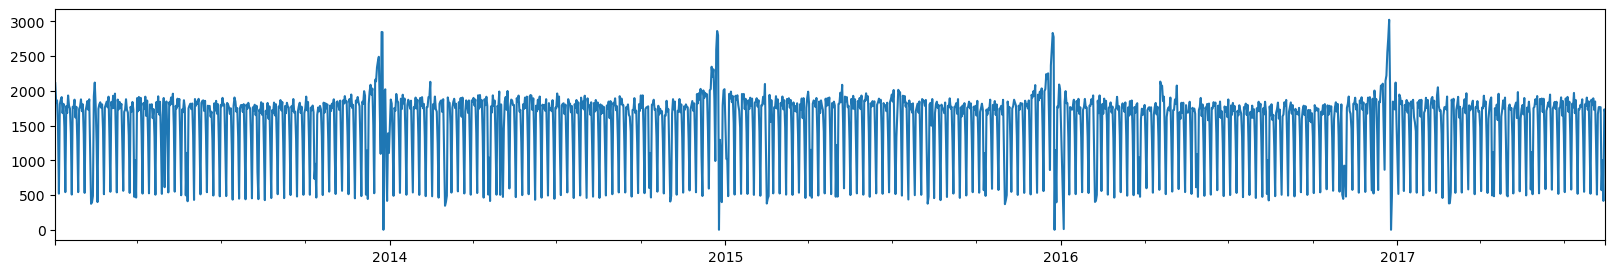

In [12]:
plt.figure(figsize=(20,3))
df1["store_trans_filled"].plot()

<Axes: >

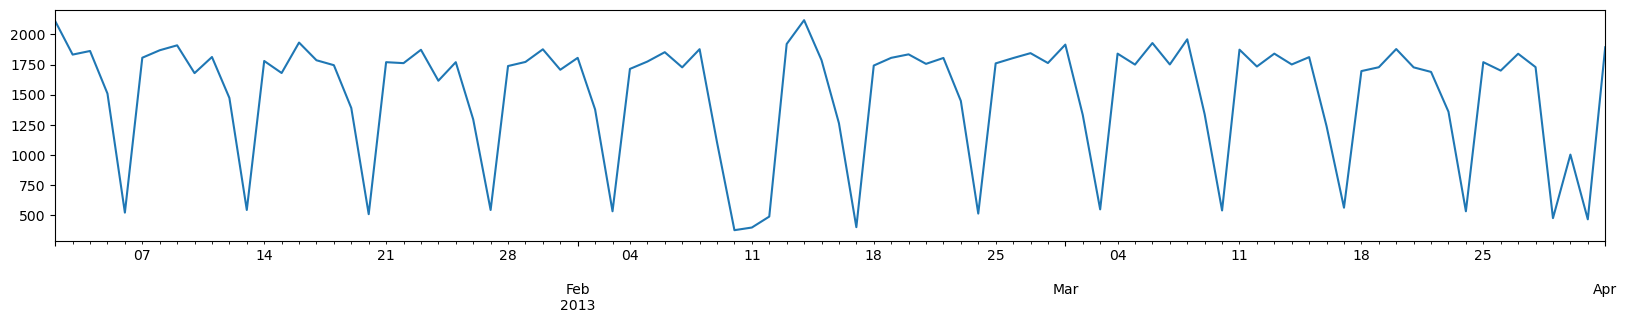

In [13]:
# zoom the dataset into several months
plt.figure(figsize=(20,3))
df1.iloc[:90,5].plot()

##### We can observe clear annual and weekly seasonality in the data without any evident trend. To apply both seasonalities, I will create model the weekly seasonality and create an exougenous feature for the annual seasonality to be considered.

In [14]:
df1["lag365"]=df1["store_trans_filled"].shift(365)
df1["lag365"]

2013-01-02       NaN
2013-01-03       NaN
2013-01-04       NaN
2013-01-05       NaN
2013-01-06       NaN
               ...  
2017-08-11    1697.0
2017-08-12     515.0
2017-08-13    1001.0
2017-08-14     423.0
2017-08-15    1776.0
Freq: D, Name: lag365, Length: 1687, dtype: float64

In [15]:
# Sanity check
df1[(df1.index>='2016-08-11') & (df1.index<='2016-08-13')]

,store_promo,year,month,day,dcoilwtico_interpolated,store_trans_filled,weekday,weekend,lag365
2016-08-11,77.0,2016.0,8.0,11.0,43.510000,1697.0,4.0,0.0,1827.0
2016-08-12,190.0,2016.0,8.0,12.0,44.470000,515.0,5.0,0.0,1499.0
2016-08-13,73.0,2016.0,8.0,13.0,44.886667,1001.0,0.0,1.0,1882.0


In [16]:
df1 = df1.dropna(subset=['lag365'])
df1

,store_promo,year,month,day,dcoilwtico_interpolated,store_trans_filled,weekday,weekend,lag365
2014-01-02,0.0,2014.0,1.0,2.0,95.140000,1875.0,4.0,0.0,2111.0
2014-01-03,0.0,2014.0,1.0,3.0,93.660000,1817.0,5.0,0.0,1833.0
2014-01-04,0.0,2014.0,1.0,4.0,93.480000,1294.0,0.0,1.0,1863.0
2014-01-05,0.0,2014.0,1.0,5.0,93.300000,489.0,0.0,1.0,1509.0
2014-01-06,0.0,2014.0,1.0,6.0,93.120000,1754.0,1.0,0.0,520.0
...,...,...,...,...,...,...,...,...,...
2017-08-11,216.0,2017.0,8.0,11.0,48.810000,570.0,5.0,0.0,1697.0
2017-08-12,103.0,2017.0,8.0,12.0,48.403333,1004.0,0.0,1.0,515.0
2017-08-13,73.0,2017.0,8.0,13.0,47.996667,416.0,0.0,1.0,1001.0
2017-08-14,120.0,2017.0,8.0,14.0,47.590000,1733.0,1.0,0.0,423.0


In [17]:
df1_train = df1[df1.index < '2017-01-01']
df1_test = df1[df1.index >= '2017-01-01']

##### Let's use the Augmented Dickey-Fuller test to check for the stationarity of the dataset.

In [18]:
# check for the trend of the dataset
result = adfuller(df1_train["store_trans_filled"])
result

(-6.185497655385073,
 6.304056254661286e-08,
 21,
 1073,
 {'1%': -3.436459052172655,
  '5%': -2.864237372528562,
  '10%': -2.568206176974609},
 15063.76281689827)

##### The ADF shows the dataset is stationary. Let's use PACF and ACF to define the values for p and q.

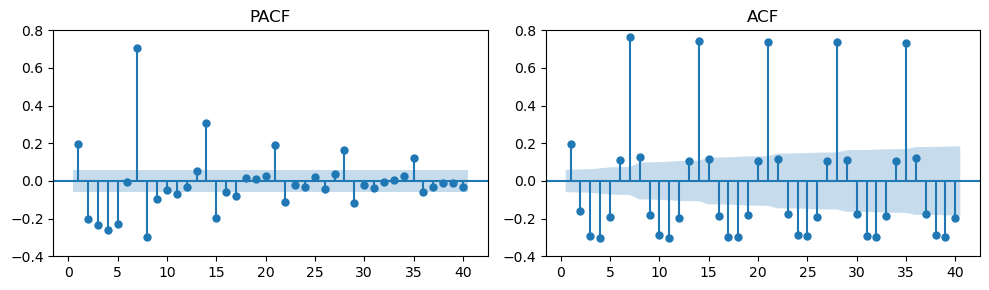

In [19]:
plt.figure(figsize=(10, 3))

# Plot PACF
plt.subplot(1, 2, 1)
plot_pacf(df1_train["store_trans_filled"], zero=False, lags=40, ax=plt.gca())
plt.title("PACF")
plt.ylim(-0.4, 0.8)

# Plot ACF
plt.subplot(1, 2, 2)
plot_acf(df1_train["store_trans_filled"], zero=False, lags=40, ax=plt.gca())
plt.title("ACF")
plt.ylim(-0.4, 0.8)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

##### I will start by tring p as 8, q as 4 since these are most significant. For simplicity, I will first try p = 4 and q = 2 since they double the effect. Now let's plot for seasonal data. Since the annual seasonality will be represented by exogenous feature 'lag365', we will consider weekly seasonality only.

C:\Users\erinb\AppData\Local\Temp\ipykernel_32912\2549742123.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_train.loc[:, "store_trans_filled_diff7"] = df1_train.loc[:, "store_trans_filled"].diff(7)


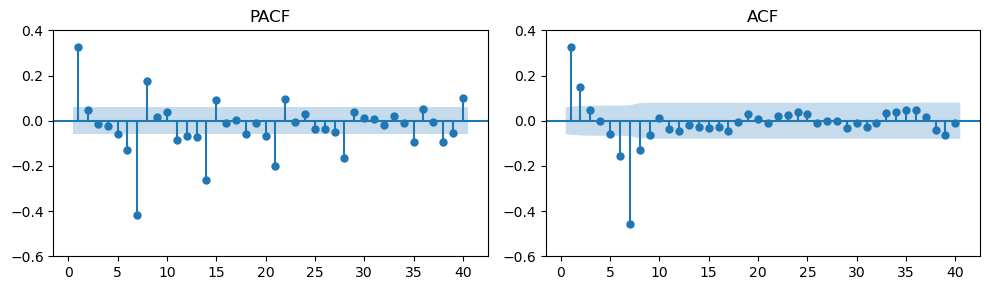

In [20]:
# Create weekly seasonal differenced data using .loc
df1_train.loc[:, "store_trans_filled_diff7"] = df1_train.loc[:, "store_trans_filled"].diff(7)
# plot pacf and acf
# Plot PACF
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plot_pacf(df1_train.loc[:,"store_trans_filled_diff7"].dropna(), zero=False, lags=40, ax=plt.gca())
plt.title("PACF")
plt.ylim(-0.6, 0.4)

# Plot ACF
plt.subplot(1, 2, 2)
plot_acf(df1_train.loc[:, "store_trans_filled_diff7"].dropna(), zero=False, lags=40, ax=plt.gca())
plt.title("ACF")
plt.ylim(-0.6, 0.4)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

##### From above chart, we will define P as 1 and Q as 2

##### Other exogenous features

In [21]:
exog_features = df1[["lag365", 'store_promo', 'dcoilwtico_interpolated', 'weekday', 'weekend']]

In [22]:
exog_train = exog_features[:'2016-12-31']
exog_test = exog_features['2017-01-01':]

In [23]:
# define the target
y_train = df1_train.store_trans_filled
y_test = df1_test.store_trans_filled

##### Use SARIMAX

In [24]:
# Define the SARIMAX model
model = SARIMAX(
    y_train,                             # Endogenous variable
    exog=exog_train,                     # Exogenous variables for training
    order=(4, 0, 2),                     # (p, d, q)
    seasonal_order=(1, 1, 2, 7)          # (P, D, Q, s) where s is the seasonal period
)

# Fit the model
results = model.fit(disp=True,maxiter=1000)

C:\Users\erinb\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\erinb\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


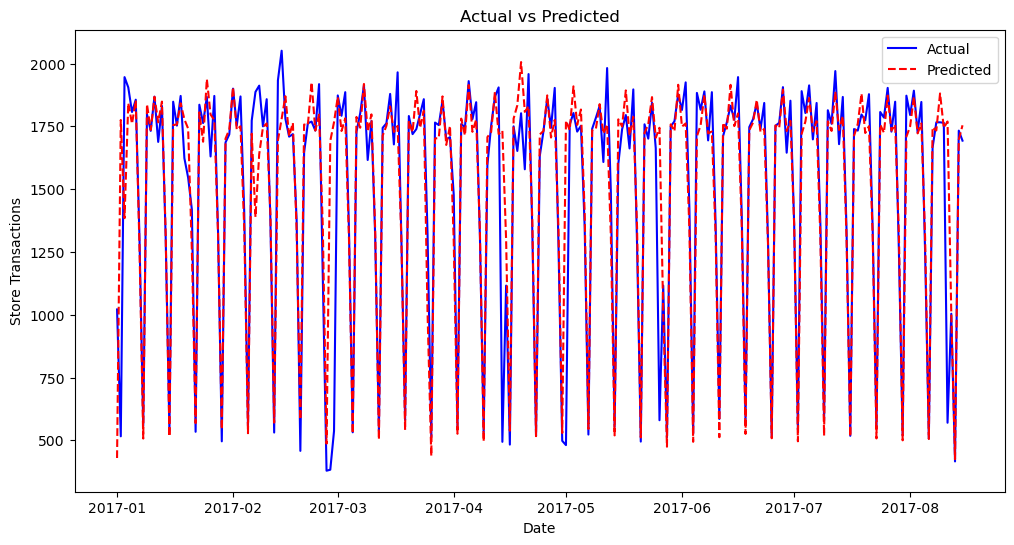

In [25]:
# Predict the values for the specified period
predictions = results.predict(
    start='2017-01-01', 
    end='2017-08-15', 
    exog=exog_test
)

# Plot the real vs predicted values
plt.figure(figsize=(12, 6))

# Plot the actual data
plt.plot(y_test, label='Actual', color='blue', linestyle='-')

# Plot the predictions
plt.plot(predictions, label='Predicted', color='red', linestyle='--')

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Store Transactions')
plt.title('Actual vs Predicted')
plt.legend()

# Display the plot
plt.show()

In [26]:
y_test.var()

237403.29055397437

In [27]:
y_test.mean()

1502.259911894273

In [28]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 105.55298685871874


##### First, I will use a wide grid search to identify possible ranges for optimal model parameters. Then, I will use a finer grid search within those ranges to pinpoint the best model.

In [27]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from itertools import product

# Define the parameter grids
p_values = [1, 8]
q_values = [1, 4]
P_values = [1, 8]
Q_values = [1, 7]

# Initialize variables to store the best model results
best_mae = np.inf
best_aic = np.inf
best_model = None
best_order = None
best_results = None

# Iterate over all combinations of p, q, P, and Q
for p, q, P, Q in product(p_values, q_values, P_values, Q_values):
    try:
        # Define and fit the SARIMAX model for each combination
        model = SARIMAX(y_train, 
                        exog=exog_train, 
                        order=(p, 0, q), 
                        seasonal_order=(P, 1, Q, 7))  # s=7 for weekly seasonality
        results = model.fit(disp=False, maxiter=1000)
        
        # Make predictions
        predictions = results.predict(start='2017-01-01', end='2017-08-15', exog=exog_test)
        
        # Calculate MAE
        mae = mean_absolute_error(y_test, predictions)
        
        # Print the results for each combination
        print(f'p={p}, q={q}, P={P}, Q={Q} | MAE={mae:.2f} | AIC={results.aic:.2f} | LLR={results.llf:.2f}')

        # Update the best model if this one is better
        if mae < best_mae:
            best_mae = mae
            best_aic = results.aic
            best_model = model
            best_order = (p, q, P, Q)
            best_results = results
            
    except Exception as e:
        print(f"Error for parameters p={p}, q={q}, P={P}, Q={Q}: {e}")

# Optionally, you can plot the best model's predictions against real data
if best_results is not None:
    best_predictions = best_results.predict(start='2017-01-01', end='2017-08-15', exog=exog_test)
    plt.figure(figsize=(10, 6))

p=1, q=1, P=1, Q=1 | MAE=103.62 | AIC=14813.11 | LLR=-7396.55
p=1, q=1, P=1, Q=7 | MAE=104.62 | AIC=14820.61 | LLR=-7394.31
p=1, q=1, P=8, Q=1 | MAE=107.10 | AIC=14817.10 | LLR=-7391.55
p=1, q=1, P=8, Q=7 | MAE=106.20 | AIC=14951.91 | LLR=-7452.95
p=1, q=4, P=1, Q=1 | MAE=107.00 | AIC=14815.06 | LLR=-7394.53
p=1, q=4, P=1, Q=7 | MAE=107.38 | AIC=14824.55 | LLR=-7393.28
p=1, q=4, P=8, Q=1 | MAE=132.03 | AIC=14815.16 | LLR=-7387.58
p=1, q=4, P=8, Q=7 | MAE=107.35 | AIC=14966.38 | LLR=-7457.19
Error for parameters p=8, q=1, P=1, Q=1: Invalid model: autoregressive lag(s) {7} are in both the seasonal and non-seasonal autoregressive components.
Error for parameters p=8, q=1, P=1, Q=7: Invalid model: autoregressive lag(s) {7} are in both the seasonal and non-seasonal autoregressive components.
Error for parameters p=8, q=1, P=8, Q=1: Invalid model: autoregressive lag(s) {7} are in both the seasonal and non-seasonal autoregressive components.
Error for parameters p=8, q=1, P=8, Q=7: Invalid mo

<Figure size 1000x600 with 0 Axes>

#### From the Gridsearch we can see that most simple model with pqPQ = 1 achieved the best result. Let's run the model again and check for the mae.

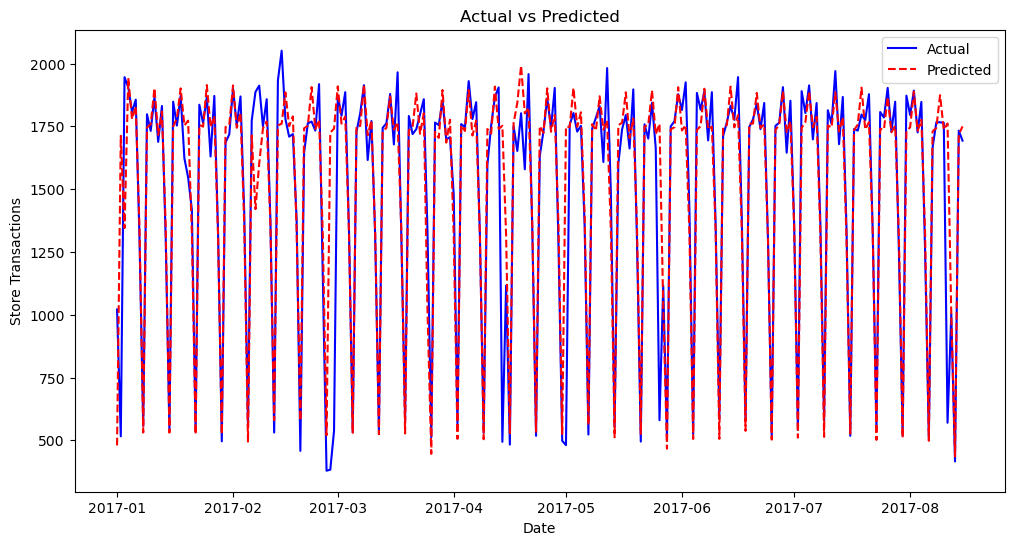

In [29]:
# Define the SARIMAX model
model = SARIMAX(
    y_train,                             # Endogenous variable
    exog=exog_train,                     # Exogenous variables for training
    order=(1, 0, 1),                     # (p, d, q)
    seasonal_order=(1, 1, 1, 7)          # (P, D, Q, s) where s is the seasonal period
)

# Fit the model
results = model.fit(disp=True,maxiter=1000)
# Predict the values for the specified period
predictions = results.predict(
    start='2017-01-01', 
    end='2017-08-15', 
    exog=exog_test
)

# Plot the real vs predicted values
plt.figure(figsize=(12, 6))

# Plot the actual data
plt.plot(y_test, label='Actual', color='blue', linestyle='-')

# Plot the predictions
plt.plot(predictions, label='Predicted', color='red', linestyle='--')

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Store Transactions')
plt.title('Actual vs Predicted')
plt.legend()

# Display the plot
plt.show()

In [30]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 103.61730603576544


In [ ]:
n=10
p=[1,2]
q=[1,2,3]
P=[1,2]
Q=[1,2]
